# Digitizing Plant Layout Data

There are serveral possible ways to digitize the plant's combiner layout data. Here is a partial overview of one way to do it using the open-source geographic information system (GIS) tool QGIS [1, 2]. There are also commercial GIS tools, as well as web-based tools like https://geojson.io/ that could possibly work. 

_NOTE: This demonstration uses an arbitrary example plant for illustration purposes. The plants used in later demos are not included here to protect their anonymity._

[1] https://qgis.org/en/site/

[2] https://github.com/qgis/QGIS

## Manually outlining combiners in QGIS

_NOTE: If your project design package includes shapefiles or other GIS-compatible data that includes combiners, you should start with that dataset as an alternative to this workflow. If you have PDF drawings, it is possible to add them as a layer in QGIS, georeference them, and then use them to trace combiner boundaries, but that is outside the scope of this demo. If you've already got your plant outlined in a GeoJSON format, you can jump ahead to Converting GeoJSON Data._

Assuming you don't already have digitized/georeferenced data for you combiners, you can use QGIS to manually outline combiners. Start by creating a new project and adding a _QuickMapServices_ layer, like _Google Hybrid_ or _Bing Satellite_. 


<img src="images/qgis_01.png" width="500"/>

Then zoom to your plant and add a new shapefile layer with _Layer_ > _Create Layer_ > _New Shapefile Layer..._

<img src="images/qgis_02.png" width="500"/>

Give the layer a name, select _Polygon_ as the goemetry type, and then add fields that can be used to filter and identify combiners. I chose to create _asset_type_ and _asset_name_ fields, where an asset type could be "combiner" or "inverter", and asset names could be things like "CMB-001-01". 

<img src="images/qgis_03.png" width="300"/>

Then draw the feature polygons and assign values for the asset types and names. 

_NOTE: QGIS has the ability to copy/paste features, lock angles, and other functionality that could help here, but that is outside the scope of this demo._ 

<img src="images/qgis_04.png" width="500"/>

Once you are done adding combiners, right-click the layer and select _Export_ > _Save Feature As..._:

<img src="images/qgis_05.png" width="500"/>

And then save as a GeoJSON file:

<img src="images/qgis_06.png" width="300"/>

_NOTE: Digitizing/georeferencing solar plant hardware is commonly done for aerial infrared (thermographic) scanning. Commercial providers of those services may be able to digitize your solar plants at a reasonable cost, and more efficiently than someone that is new to these processes._

## Converting GeoJSON data

Now that we have a GeoJSON file, we can use Python to convert it to relative coordinates in meters. 

In [1]:
# we need geopandas and matplotlib, which are not automatically installed, so we'll install them if they're not present.
try:
    import geopandas as gpd
except ImportError:
    !pip install geopandas
    import geopandas as gpd

try:
    import matplotlib
except ImportError:
    !pip install matplotlib
    
import pandas as pd


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/c4/64/7d344cfcef5efddf9cf32f59af7f855828e9d74b5f862eddf5bfd9f25323/geopandas-1.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for pyogrio>=0.7.2 from https://files.pythonhosted.org/packages/c3/fa/45efa8c96744ddd92c3ce3a80ddba8512954cc7c5407876e2ff2ffea0c10/pyogrio-0.9.0-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for shapely>=2.0.0 from https://files.pythonhosted.org/packages/d4/c3/e98e3eb9f06def32b8e2454ab718cafb99149f023dff023e257125132d6e/shapely-2.0.5-cp312-cp312-win_amd64.whl.metadata
   ---------------------------------------- 0.0/323.6 kB ? eta -:--:--
   ---- ---------------------------------- 41.0/323.6 kB 960.0 kB/s eta 0:00:01
   ------------------------ --------------- 194.6/323.6 kB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 323.6/323.6 kB 2.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.9 MB 

Read in the GeoJSON file that we created with QGIS and preview the resulting DataFrame, which uses latitude and longitude coordinates in degrees:

In [2]:
data = gpd.read_file('data/digitized_plant.geojson')
data.head()

,id,asset_type,asset_name,geometry
0,None,combiner,CMB-001-01,"MULTIPOLYGON (((-83.67303 33.68023, -83.67303 ..."
1,None,combiner,CMB-001-02,"MULTIPOLYGON (((-83.67282 33.68006, -83.67282 ..."
2,None,combiner,CMB-001-03,"MULTIPOLYGON (((-83.67261 33.67975, -83.67261 ..."
3,None,combiner,CMB-001-04,"MULTIPOLYGON (((-83.6724 33.67946, -83.6724 33..."
4,None,combiner,CMB-001-05,"MULTIPOLYGON (((-83.6722 33.67916, -83.6722 33..."


We want to create an anonymized dataset, where the distances are preserved, but the absolute position is relative to the plant. Set the origin latitude and longitude using the minimum latitude and longitude values (Southwest corner of the plant, in this case):

In [3]:
origin_long = data.geometry.get_coordinates().x.min()
origin_lat = data.geometry.get_coordinates().y.min()

We'll then project by defining a custom coordinate reference system (CRS) using meters and based on that origin point. The `proj=aeqd` part of the projection creates an [azimuthal equidistant projection](https://proj4.org/en/9.4/operations/projections/aeqd.html), which is useful for measuring distances from a single point.

In [4]:
custom_crs = "+proj=aeqd +lat_0=" + \
    str(origin_lat) + " +lon_0=" + \
    str(origin_long) + " +datum=WGS84 +units=m"

# Convert to custom coordinate system
data_utm = data.to_crs(custom_crs)

A quick plot to preview the combiners in the resulting data:

<Axes: >

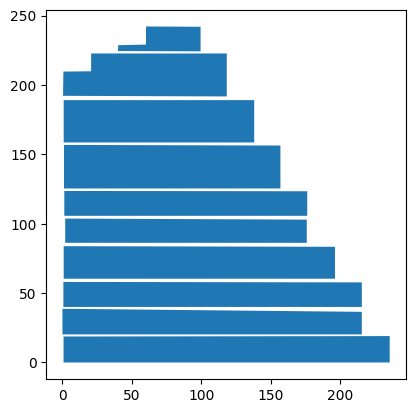

In [5]:
data_utm.loc[data_utm['asset_type']=='combiner'].plot(aspect='equal')

And write the results to a new GeoJSON file that uses meters relative to the plant corner for coordinates. The location of the plant is now anonymized.

In [6]:
# Write new file
data_utm.to_file('data/digitized_plant_meters.geojson', driver='GeoJSON') 
data_utm.head()

,id,asset_type,asset_name,geometry
0,None,combiner,CMB-001-01,"MULTIPOLYGON (((99.546 241.961, 99.546 224.268..."
1,None,combiner,CMB-001-02,"MULTIPOLYGON (((118.433 222.72, 118.433 191.75..."
2,None,combiner,CMB-001-03,"MULTIPOLYGON (((138.209 189.103, 138.21 158.58..."
3,None,combiner,CMB-001-04,"MULTIPOLYGON (((157.097 156.37, 157.097 125.40..."
4,None,combiner,CMB-001-05,"MULTIPOLYGON (((176.429 123.416, 176.429 105.7..."


## Exporting Data for Use by SolarSpatialTools
The data is now converted to a relative rectilinear coordinate system. One data item that we frequently need for analyses (e.g. `field`) is the centroid of these positions. We can extract that data and save it to a convenient format, like CSV or h5. 

Since the shapes in the GeoJSON file are polygons, we can get the centroid of each shape using the `centroid` attribute. We will store this in a standard pandas DataFrame, indexed by the `asset_name` field that we created. We will also filter on `asset_type` of `combiner`, so that we don't include centroids of other assets that may have been digitized.

In [7]:
data_boundaries = data_utm.loc[data_utm['asset_type']=='combiner']
data_centroids = pd.DataFrame(
    data_boundaries.centroid.get_coordinates().values,
    index=data_utm.asset_name, columns=['E', 'N']
    )
data_centroids.head()

,E,N
asset_name,,
CMB-001-01,76.504393,232.462541
CMB-001-02,63.430049,206.657679
CMB-001-03,69.549150,173.841325
CMB-001-04,78.919717,140.997993
CMB-001-05,88.699994,114.623431


You could now save the data as desired. Examples of CSV and h5 formats are shown below.

In [8]:
data_centroids.to_csv(f'data/digitized_plant_centroids.csv')
data_centroids.to_hdf(f'data/digitized_plant_centroids.h5', key='utm', mode='a', append=True)